In [1]:
import os

import dgl
import dgl.data
import dgl.function as fn
import dgl.nn.functional as dF
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 节点分类

## 数据集

In [2]:
dataset = dgl.data.CoraGraphDataset("./")

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
print("n of categories: ", dataset.num_classes)
print("n of graph", len(dataset))

n of categories:  7
n of graph 1


In [14]:
g = dataset[0]
in_feats = g.ndata["feat"].shape[1]
out_feats = dataset.num_classes
print(in_feats, out_feats)

1433 7


### 测试图

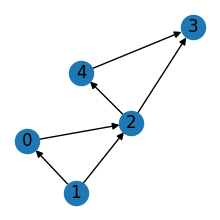

In [181]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.rand((5, 8))

g = dgl.graph((src, dst))
g.ndata["h"] = h
edge_weight = torch.ones(g.num_edges())  # 给各个边赋格权重
g.edata["edge_weight"] = edge_weight
plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)


in_feats = h.shape[1]
out_feats = 6

## GraphConv
Mathematically it is defined as follows:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $\mathcal{N}(i)$ is the set of neighbors of node $i$, 
$c_{ji}$ is the product of the square root of node degrees
$(i.e.,  c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|})$,
and $\sigma$ is an activation function.

If a weight tensor on each edge is provided, the weighted graph convolution is defined as:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{e_{ji}}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $e_{ji}$is the scalar weight on the edge from node $j$ to node $i$.
This is NOT equivalent to the weighted graph convolutional network formulation in the paper.

To customize the normalization term :$c_{ji}$, one can first set ``norm='none'`` for
the model, and send the pre-normalized :$e_{ji}$ to the forward computation. We provide
:class:`~dgl.nn.pytorch.EdgeWeightNorm` to normalize scalar edge weight following the GCN paper.

In [85]:
# 自定义GraphConv
class myGraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(myGraphConv, self).__init__()
        self.w = nn.Linear(in_feats, out_feats, bias=False)
        self.bias = nn.Parameter(torch.Tensor(out_feats))  # 定义tensor类型的bias

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.w.weight)
        nn.init.zeros_(self.bias)

    def forward(self, g: dgl.DGLGraph, x):
        with g.local_scope():
            # 确保自身特征能有迭代
            g = dgl.remove_self_loop(g)
            g = dgl.add_self_loop(g)

            # norm='both'，cij考虑src的出度和dst的入度
            out_deg = g.out_degrees().pow(-0.5)
            in_deg = g.in_degrees().pow(-0.5)

            g.srcdata["out_deg"] = out_deg
            g.srcdata["in_deg"] = in_deg

            h = self.w(x)
            g.srcdata["h"] = h

            g.update_all(message_func=self.message, reduce_func=fn.sum("hN", "hN"))
            hN = g.dstdata["hN"] + self.bias

            return hN

    def message(self, edges: dgl.udf.EdgeBatch):
        d_j = edges.src["out_deg"].view(-1, 1)
        d_i = edges.dst["in_deg"].view(-1, 1)
        h_j = edges.src["h"]

        hN = d_i * d_j * h_j
        return {"hN": hN}

In [87]:
# myGraphConv(in_feats,out_feats)(g,g.ndata['feat'])

## GCN

In [88]:
# 自定义GCN模型
class myGCN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(myGCN, self).__init__()
        self.conv1 = myGraphConv(in_feats, in_feats)
        self.conv2 = myGraphConv(in_feats, out_feats)

    def forward(self, g, x):
        h = self.conv1(g, x)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

### 训练和测试

In [113]:
# 训练
def train():
    model.train()
    optimzier.zero_grad()

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]

    logits = model(g, features)
    loss = criterion(logits[train_mask], labels[train_mask])

    loss.backward()
    optimzier.step()

    return loss.detach()


# 测试
def test():
    model.eval()
    with torch.no_grad():
        features = g.ndata["feat"]
        labels = g.ndata["label"]
        train_mask = g.ndata["train_mask"]
        val_mask = g.ndata["val_mask"]
        test_mask = g.ndata["test_mask"]

        logits = model(g, features)
        pred = logits.argmax(1)

        train_acc = (pred[train_mask] == labels[train_mask]).float().mean().item()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean().item()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean().item()

    return train_acc, test_acc, val_acc

In [115]:
def visualize_curve(train_acc, test_acc, val_acc):
    if train_acc is not None:
        plt.plot(train_acc, label="train")
    if val_acc is not None:
        plt.plot(val_acc, label="val")
    if test_acc is not None:
        plt.plot(test_acc, label="test")
    plt.legend()
    plt.show()

In [116]:
device = "cuda"
model = myGCN(in_feats, out_feats).to(device)
g = g.to(device)

optimzier = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy

In [117]:
train_accs, test_accs, val_accs = [], [], []

for e in range(101):
    loss = train()

    if e % 10 == 0:
        train_acc, test_acc, val_acc = test()
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        val_accs.append(val_acc)
        print(
            f"Epoch: {e:03d}, loss: {loss:.4f}, \
        train_acc: {train_acc:.3f}, val_acc: {val_acc:.3f}, test_acc: {test_acc:.3f}"
        )

Epoch: 000, loss: 1.9460,         train_acc: 0.829, val_acc: 0.532, test_acc: 0.539
Epoch: 010, loss: 1.8009,         train_acc: 0.957, val_acc: 0.690, test_acc: 0.725
Epoch: 020, loss: 1.5633,         train_acc: 0.971, val_acc: 0.726, test_acc: 0.753
Epoch: 030, loss: 1.2453,         train_acc: 0.986, val_acc: 0.774, test_acc: 0.786
Epoch: 040, loss: 0.8965,         train_acc: 0.986, val_acc: 0.778, test_acc: 0.799
Epoch: 050, loss: 0.5931,         train_acc: 0.986, val_acc: 0.786, test_acc: 0.809
Epoch: 060, loss: 0.3788,         train_acc: 0.986, val_acc: 0.786, test_acc: 0.812
Epoch: 070, loss: 0.2448,         train_acc: 0.986, val_acc: 0.788, test_acc: 0.814
Epoch: 080, loss: 0.1641,         train_acc: 1.000, val_acc: 0.780, test_acc: 0.809
Epoch: 090, loss: 0.1151,         train_acc: 1.000, val_acc: 0.784, test_acc: 0.804
Epoch: 100, loss: 0.0846,         train_acc: 1.000, val_acc: 0.788, test_acc: 0.799


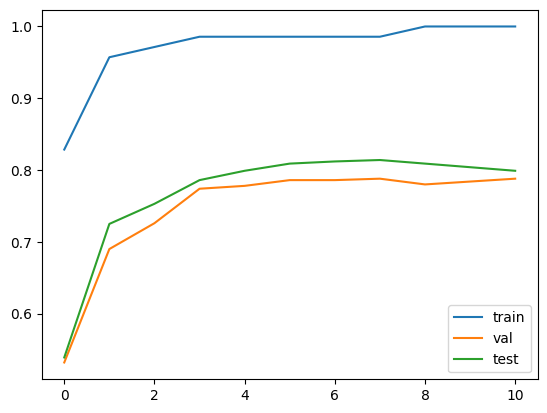

In [118]:
visualize_curve(train_accs, test_accs, val_accs)

# 连接预测

## 数据集

In [37]:
dataset = dgl.data.CoraGraphDataset("./")

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


### 准备边

In [113]:
g = dataset[0]
num_nodes = g.num_nodes()
num_edges = g.num_edges()

num_train_edges = int(num_edges * 0.8)
num_test_edges = num_edges - num_train_edges


u, v = g.edges()
eids = torch.arange(num_edges)

# 正边
idx = torch.randperm(num_edges)
train_u_pos, train_v_pos = u[idx[:num_train_edges]], v[idx[:num_train_edges]]
test_u_pos, test_v_pos = u[idx[num_train_edges:]], v[idx[num_train_edges:]]

# 负边
edge_index = torch.cat([u.view(1, -1), v.view(1, -1)], dim=0)
adj_coo = torch.sparse_coo_tensor(
    indices=edge_index, values=torch.ones(num_edges), size=(num_nodes, num_nodes)
)
adj = adj_coo.to_dense()
adj_neg = 1 - adj - torch.eye(num_nodes)

u_neg, v_neg = torch.where(adj_neg == 1)

idx = torch.randperm(num_edges)
train_u_neg, train_v_neg = u_neg[idx[:num_train_edges]], v_neg[idx[:num_train_edges]]
test_u_neg, test_v_neg = u_neg[idx[num_train_edges:]], v_neg[idx[num_train_edges:]]


print("训练集正样本边个数：", len(train_u_pos))
print("训练集负样本边个数：", len(train_u_neg))
print("测试集正样本边个数：", len(test_u_pos))
print("测试集负样本边个数：", len(test_u_neg))
g = dataset[0]
in_feats = g.ndata["feat"].shape[1]
out_feats = dataset.num_classes
print(in_feats, out_feats)


# 移除测试边
train_g = dgl.remove_edges(g, idx[num_train_edges:])
print(train_g)


train_g_pos = dgl.graph((train_u_pos, train_v_pos), num_nodes=g.num_nodes())
train_g_neg = dgl.graph((train_u_neg, train_v_neg), num_nodes=g.num_nodes())

test_g_pos = dgl.graph((test_u_pos, test_v_pos), num_nodes=g.num_nodes())
test_g_neg = dgl.graph((test_u_neg, test_v_neg), num_nodes=g.num_nodes())

训练集正样本边个数： 8444
训练集负样本边个数： 8444
测试集正样本边个数： 2112
测试集负样本边个数： 2112
1433 7
Graph(num_nodes=2708, num_edges=8444,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})


## GATConv

In [47]:
from dgl.nn.functional import edge_softmax


class myGATConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(myGATConv, self).__init__()
        # self.W=nn.Parameter(torch.rand(in_feats,out_feats))
        # self.a=nn.Parameter(torch.rand(2*in_feats,1))
        self.W = nn.Linear(in_feats, out_feats, bias=False)
        self.a_fc = nn.Linear(out_feats * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU()

    def edge_attention(self, edges):
        hiW = self.W(edges.dst["h"])
        hjW = self.W(edges.src["h"])
        h_cat = torch.cat([hiW, hjW], dim=1)
        e = self.leakyrelu(self.a_fc(h_cat))
        return {"e": e}

    def forward(self, g: dgl.graph, h, get_attention=False):
        with g.local_scope():
            g = g.remove_self_loop().add_self_loop()
            g.ndata["h"] = h
            g.apply_edges(self.edge_attention)
            e = g.edata["e"]
            alpha = edge_softmax(g, e)
            g.edata["alpha"] = alpha
            hW = self.W(h)

            g.ndata["hW"] = hW
            g.update_all(fn.u_mul_e("hW", "alpha", "m"), fn.sum("m", "hN"))
            hN = g.ndata["hN"]

            if get_attention:
                return hN, alpha
            else:
                return hN

## GAT
用于提取特征，提取出的特征传入给MLPPredictor来分类

In [48]:
# 自定义GCN模型
class myGAT(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(myGAT, self).__init__()
        self.conv1 = myGATConv(in_feats, in_feats)
        self.conv2 = myGATConv(in_feats, out_feats)

    def forward(self, g, x):
        h = self.conv1(g, x)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

### MLPPredictor

In [49]:
class MLPPredictor(nn.Module):
    def __init__(self, n_feats):
        super(MLPPredictor, self).__init__()
        self.w1 = nn.Linear(n_feats * 2, n_feats)
        self.w2 = nn.Linear(n_feats, 1)

    def forward(self, g: dgl.DGLGraph, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.apply_edges(self.apply_edges)
            return g.edata["score"]

    def apply_edges(self, edges):
        h1 = edges.src["h"]
        h2 = edges.src["h"]
        h = torch.cat([h1, h2], dim=1)

        h = self.w2(F.relu(self.w1(h)))

        return {"score": h}

#### 训练和测试

In [50]:
from sklearn.metrics import roc_auc_score


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [183]:
import itertools

device = "cuda"
train_g = train_g.to(device)

train_g_pos = train_g_pos.to(device)
train_g_neg = train_g_neg.to(device)


model = myGAT(in_feats, 32).to(device)
predictor = MLPPredictor(32).to(device)


In [184]:
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), predictor.parameters()), lr=0.01
)

In [185]:
def train():
    h = model(train_g, train_g.ndata["feat"])
    pos_score = predictor(train_g_pos, h)
    neg_score = predictor(train_g_neg, h)
    scores = torch.cat([pos_score, neg_score]).squeeze().cuda()
    labels = torch.cat(
        [
            torch.ones(pos_score.shape[0]),
            torch.zeros(neg_score.shape[0]),
        ]
    ).cuda()
    loss = F.binary_cross_entropy_with_logits(scores, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def test():
    model.eval()
    with torch.no_grad():
        h = model(train_g, train_g.ndata["feat"]).cuda()
        pos_score = predictor(train_g_pos.to(device), h).cpu()
        neg_score = predictor(train_g_neg.to(device), h).cpu()

        # print("AUC", compute_auc(pos_score, neg_score))
        return compute_auc(pos_score, neg_score)

In [186]:
for e in range(101):
    loss = train()
    if e % 10 == 0:
        print(f"epoch {e}, loss: {loss:.6f}, AUC: {test():.6f}")

epoch 0, loss: 0.697182, AUC: 0.999109
epoch 10, loss: 0.016028, AUC: 0.999274
epoch 20, loss: 0.026334, AUC: 0.999168
epoch 30, loss: 0.024987, AUC: 0.998944
epoch 40, loss: 0.014972, AUC: 0.998399
epoch 50, loss: 0.034451, AUC: 0.997176
epoch 60, loss: 0.010519, AUC: 0.999127
epoch 70, loss: 0.007718, AUC: 0.999247
epoch 80, loss: 0.006616, AUC: 0.999306
epoch 90, loss: 0.005921, AUC: 0.999490
epoch 100, loss: 0.005579, AUC: 0.999229
